In [53]:
# In[1]:


import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
from popsims import sample_from_powerlaw
import popsims
from gala.units import UnitSystem
import pandas as pd
from scipy.interpolate import interp1d, griddata, InterpolatedUnivariateSpline
from astropy.io.votable import parse_single_table
import numba
plot_style()
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm import tqdm
#get_ipython().run_line_magic('matplotlib', 'inline')


# In[2]:
from popsims.plot_style import plot_style
plot_style()


path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'

In [2]:
class M31Halo(GalacticComponent):
    """
    power-law stellar density for M31's halo by Ibata et al. 2014
    
    """
    def __init__(self, q=1.11, gamma=-3):
        super().__init__({'q': q, 'gamma': gamma})

    def stellar_density(self, r, z):
        """
        Compute the stellar density at a particular position

        Args:
        ----
            x, y, z: galacto-centric x, y,z ( astropy.quantity )
        Returns:
        -------
            unit-less stellar density

        Examples:
        --------
            > d = Disk.stellar_density(100*u.pc, -100*u.pc)
        """
        #add a raise error if r <0
        
        s= (r**2+(z/self.q)**2)**0.5

        return s**self.gamma

In [17]:
nsample=1e4
d_M31=770*u.kpc
model=M31Halo()
ds=np.concatenate([model.sample_distances(0.1, 200_000, 1000,  dsteps=1000) for x in range(0, 100)])
ds=np.random.choice(ds, int(nsample))

eta= 2*np.pi*np.random.uniform(0, 1, len(ds))
xi= np.arccos(2*np.random.uniform(0, 1, len(ds))-1)-np.pi/2
r, z= popsims.galaxy.transform_tocylindrical(eta, xi, ds)

#get x, y as xl cos b or something
#add the center for M31
distances_to_use=d_M31.to(u.pc).value+z

mw_model=Disk(L=2600, H=350)+0.12*Disk(L=3600, H=900)+0.0025*Halo()
    
ds=np.concatenate([mw_model.sample_distances(0.1, 200_000, 1000,  dsteps=1000) for x in range(0, 100)])
l= 2*np.pi*np.random.uniform(0, 1, len(ds))
b= np.arccos(2*np.random.uniform(0, 1, len(ds))-1)-np.pi/2
rm, zm= popsims.galaxy.transform_tocylindrical(l, b, ds)


[Text(0, 0.5, 'Normalized Density of Stars'),
 Text(0.5, 0, 'R (kpc)'),
 None,
 [Text(10, 0, '10'),
  Text(50, 0, '50'),
  Text(100, 0, '100'),
  Text(150, 0, '150'),
  Text(200, 0, '200')]]

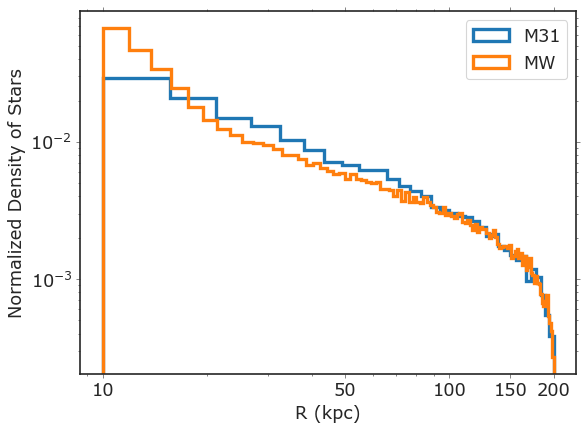

In [54]:
fig, ax=plt.subplots()
_= plt.hist( np.abs(r/1000),  bins='auto', histtype='step', 
            density=True, log=True, label='M31', linewidth=3, range=[10,200])
_= plt.hist( np.abs(rm/1000), bins=100,  histtype='step',\
            density=True, log=True, label='MW',  linewidth=3,  range=[10,200])
plt.legend()
ax.minorticks_on()
ax.set(ylabel='Normalized Density of Stars', xlabel=r'R (kpc)', xscale='log', xticks=[10, 50, 100, 150, 200],
      xticklabels=[10, 50, 100, 150, 200])


In [5]:
rgc='50_60'
fname=path_isochrone+'simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
df=pd.read_csv(fname)

#put to the desired distance modulus 
mw_df= df.query("galaxy == 'MW'").reset_index(drop=True)
m31_df= df.query("galaxy =='M31'").reset_index(drop=True)

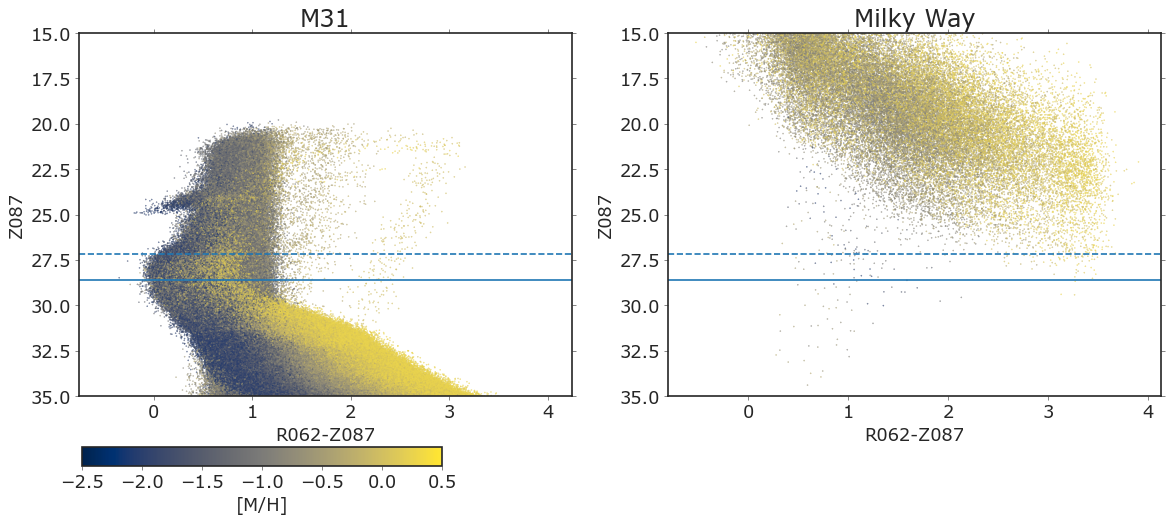

In [55]:
fig, ax=plt.subplots(ncols=2, figsize=(10*1.5, 4*1.5))

ax[0].set(title='M31')
ax[1].set(title='Milky Way')
p=ax[0].scatter(m31_df.appF062mag-m31_df.appF087mag, m31_df.appF087mag, s=.1, \
              c=m31_df.MH,  cmap='cividis', vmin=-2.5, vmax=0.5)
ax[0].invert_yaxis()
ax[0].set(ylim=[35, 15])


ax[1].scatter(mw_df.appF062mag-mw_df.appF087mag, mw_df.appF087mag, s=.1, \
              c=mw_df.MH,  cmap='cividis',  vmin=-2.5, vmax=0.5)
ax[1].invert_yaxis()
ax[1].set(ylim=[35, 15])

for a in ax:
    a.axhline(28.59, linestyle='-')
    a.axhline(27.15, linestyle='--')
    a.set(xlabel= 'R062-Z087', ylabel='Z087')

plt.tight_layout()
cax = fig.add_axes([0.08, 0., .3, 0.04])
plt.colorbar(p, ax=ax, cax=cax, orientation='horizontal')
cax.set(xlabel=r'[M/H]')
plt.savefig('../figures/simulated_CMD_CFHT.jpeg')

In [10]:
fig,a